In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset 
from torch.utils.data import DataLoader 
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 

In [2]:
df = pd.read_csv('nba_engineered_game_df.csv')
df = df.drop(columns=['matchup_id', 'date', 'next_matchup_date'])
pd.set_option('display.max_columns',None)
df.head()

,Team_A,Team_B,Team_A_+/-_basic_max,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_totals,Team_A_GmSc_basic_max,Team_A_ORtg_advanced_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_TS%_advanced_totals,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_ORtg_advanced_totals,Team_B_TS%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_DRtg_advanced_totals_last5,Team_A_FG%_basic_totals_last5,Team_A_FG_basic_max_last5,Team_A_GmSc_basic_max_last5,Team_A_ORtg_advanced_max_last5,Team_A_ORtg_advanced_totals_last5,Team_A_PTS_basic_max_last5,Team_A_Q1_last5,Team_A_TS%_advanced_totals_last5,Team_A_USG%_advanced_max_last5,Team_A_eFG%_advanced_totals_last5,Team_B_win_last5,Team_B_+/-_basic_max_last5,Team_B_3PAr_advanced_max_last5,Team_B_DRtg_advanced_max_last5,Team_B_DRtg_advanced_totals_last5,Team_B_FG%_basic_totals_last5,Team_B_GmSc_basic_max_last5,Team_B_ORtg_advanced_max_last5,Team_B_ORtg_advanced_totals_last5,Team_B_PTS_basic_max_last5,Team_B_TRB%_advanced_totals_last5,Team_B_TS%_advanced_max_last5,Team_B_TS%_advanced_totals_last5,Team_B_eFG%_advanced_max_last5,Team_B_eFG%_advanced_totals_last5,Team_A_win_last10,Team_A_+/-_basic_max_last10,Team_A_3P%_basic_totals_last10,Team_A_DRtg_advanced_max_last10,Team_A_DRtg_advanced_totals_last10,Team_A_FG%_basic_totals_last10,Team_A_FGA_basic_max_last10,Team_A_FG_basic_max_last10,Team_A_FT_basic_max_last10,Team_A_GmSc_basic_max_last10,Team_A_ORtg_advanced_max_last10,Team_A_ORtg_advanced_totals_last10,Team_A_PTS_basic_max_last10,Team_A_PTS_basic_totals_last10,Team_A_Q1_last10,Team_A_TRB%_advanced_totals_last10,Team_A_TS%_advanced_max_last10,Team_A_TS%_advanced_totals_last10,Team_A_USG%_advanced_max_last10,Team_A_eFG%_advanced_totals_last10,Team_B_win_last10,Team_B_+/-_basic_max_last10,Team_B_3P%_basic_totals_last10,Team_B_3PAr_advanced_max_last10,Team_B_DRB_basic_totals_last10,Team_B_DRtg_advanced_max_last10,Team_B_DRtg_advanced_totals_last10,Team_B_FG%_basic_totals_last10,Team_B_FG_basic_max_last10,Team_B_FT_basic_max_last10,Team_B_GmSc_basic_max_last10,Team_B_ORtg_advanced_max_last10,Team_B_ORtg_advanced_totals_last10,Team_B_PTS_basic_max_last10,Team_B_PTS_basic_totals_last10,Team_B_TRB%_advanced_totals_last10,Team_B_TS%_advanced_max_last10,Team_B_TS%_advanced_totals_last10,Team_B_USG%_advanced_max_last10,Team_B_eFG%_advanced_max_last10,Team_B_eFG%_advanced_totals_last10,H2H_last5_Team_A_+/-_basic_max,H2H_last5_Team_A_AST_basic_max,H2H_last5_Team_A_AST_basic_totals,H2H_last5_Team_A_BLK_basic_totals,H2H_last5_Team_A_DRB_basic_totals,H2H_last5_Team_A_DRtg_advanced_max,H2H_last5_Team_A_DRtg_advanced_totals,H2H_last5_Team_A_FG%_basic_totals,H2H_last5_Team_A_FG_basic_max,H2H_last5_Team_A_FG_basic_totals,H2H_last5_Team_A_GmSc_basic_max,H2H_last5_Team_A_ORtg_advanced_totals,H2H_last5_Team_A_PTS_basic_max,H2H_last5_Team_A_PTS_basic_totals,H2H_last5_Team_A_Q1,H2H_last5_Team_A_Q3,H2H_last5_Team_A_TRB%_advanced_totals,H2H_last5_Team_A_TRB_basic_totals,H2H_last5_Team_A_TS%_advanced_totals,H2H_last5_Team_A_eFG%_advanced_totals,H2H_last5_Team_B_+/-_basic_max,H2H_last5_Team_B_BLK_basic_totals,H2H_last5_Team_B_DRB_basic_totals,H2H_last5_Team_B_DRtg_advanced_max,H2H_last5_Team_B_DRtg_advanced_totals,H2H_last5_Team_B_FG%_basic_totals,H2H_last5_Team_B_GmSc_basic_max,H2H_last5_Team_B_ORtg_advanced_totals,H2H_last5_Team_B_PTS_basic_totals,H2H_last5_Team_B_Q1,H2H_last5_Team_B_TRB%_advanced_totals,H2H_last5_Team_B_TRB_basic_totals,H2H_last5_Team_B_TS%_advanced_totals,H2H_last5_Team_B_eFG%_advanced_totals,Team_A_Elo_after_current_game,Team_B_Elo_after_current_game,Team_A_Elo_before_next_matchup,Team_B_Elo_before_next_matchup,elo_diff_before_next_matchup,Elo_diff_after_current_game,Team_A_Season_WinPct_after_current,Team_B_Season_WinPct_after_current,Team_A_Season_WinPct_before_next_matchup,Team_B_Season_WinPct_before_next_matchup,Team_A_H2H_WinPct_before_next_matchup,Team_

In [3]:
y = df['Team_A_win_next']
df = df.drop(columns=['Team_A_win_next'])

train_size = int(0.7 * len(df))  
val_size = int(0.15 * len(df))   
test_size = len(df) - train_size - val_size  

x_train = df.iloc[:train_size]
x_val = df.iloc[train_size:train_size+val_size]
x_test = df.iloc[train_size+val_size:]

y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:train_size+val_size]
y_test = y.iloc[train_size+val_size:]

In [4]:
all_columns = df.columns.tolist()
binary_cols = [col for col in x_train.columns if x_train[col].nunique() == 2]
team_cols = ['Team_A', 'Team_B']
normalize_cols = [col for col in all_columns if col not in binary_cols and col not in team_cols]

x_train_norm_vals = x_train[normalize_cols].to_numpy()
x_val_norm_vals = x_val[normalize_cols].to_numpy()
x_test_norm_vals = x_test[normalize_cols].to_numpy()

x_train_binary_vals = x_train[binary_cols].to_numpy()
x_val_binary_vals = x_val[binary_cols].to_numpy()
x_test_binary_vals = x_test[binary_cols].to_numpy()

x_train_team_vals = x_train[team_cols].to_numpy()
x_val_team_vals = x_val[team_cols].to_numpy()
x_test_team_vals = x_test[team_cols].to_numpy()

team_a_train_vals = x_train_team_vals[:, 0]
team_b_train_vals = x_train_team_vals[:, 1]

team_a_val_vals = x_val_team_vals[:, 0]
team_b_val_vals = x_val_team_vals[:, 1]

team_a_test_vals = x_test_team_vals[:, 0]
team_b_test_vals = x_test_team_vals[:, 1]

mean = x_train[normalize_cols].mean().values
std = x_train[normalize_cols].std().values

x_train_norm_vals = (x_train_norm_vals - mean) / std
x_val_norm_vals = (x_val_norm_vals - mean) / std
x_test_norm_vals = (x_test_norm_vals - mean) / std

x_train = np.hstack((x_train_norm_vals, x_train_binary_vals)).astype('float32')
x_val = np.hstack((x_val_norm_vals, x_val_binary_vals)).astype('float32')
x_test = np.hstack((x_test_norm_vals, x_test_binary_vals)).astype('float32')

In [5]:
device = torch.device('mps')
print(f'Using device: {device}')

x_train = torch.tensor(x_train, dtype=torch.float32, device=device)
x_val = torch.tensor(x_val, dtype=torch.float32, device=device)
x_test = torch.tensor(x_test, dtype=torch.float32, device=device)

team_a_train = torch.tensor(team_a_train_vals, dtype=torch.long, device=device)
team_b_train = torch.tensor(team_b_train_vals, dtype=torch.long, device=device)

team_a_val = torch.tensor(team_a_val_vals, dtype=torch.long, device=device)
team_b_val = torch.tensor(team_b_val_vals, dtype=torch.long, device=device)

team_a_test = torch.tensor(team_a_test_vals, dtype=torch.long, device=device)
team_b_test = torch.tensor(team_b_test_vals, dtype=torch.long, device=device)

y_train = torch.from_numpy(y_train.to_numpy().reshape(-1, 1)).to(torch.float32).to(device)
y_val = torch.from_numpy(y_val.to_numpy().reshape(-1, 1)).to(torch.float32).to(device).detach()
y_test = torch.from_numpy(y_test.to_numpy().reshape(-1, 1)).to(torch.float32).to(device).detach()

print(f"x_train dense tensor shape: {x_train.shape}")
print(f"y_train dense tensor shape: {y_train.shape}")
print(f"team_a_train tensor shape: {team_a_train.shape}")
print(f"team_b_train tensor shape: {team_b_train.shape}")

Using device: mps
x_train dense tensor shape: torch.Size([13108, 158])
y_train dense tensor shape: torch.Size([13108, 1])
team_a_train tensor shape: torch.Size([13108])
team_b_train tensor shape: torch.Size([13108])


In [6]:
train_dataset = TensorDataset(x_train, team_a_train, team_b_train, y_train)
val_dataset = TensorDataset(x_val, team_a_val, team_b_val, y_val)
test_dataset = TensorDataset(x_test, team_a_test, team_b_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
class CrossLayerV2(nn.Module): 
    def __init__(self, input_dim: int): 
        super(CrossLayerV2, self).__init__() 
        self.w = nn.Parameter(torch.empty(input_dim, input_dim)) 
        self.b = nn.Parameter(torch.empty(input_dim))
        nn.init.xavier_uniform_(self.w)
        nn.init.zeros_(self.b)
    
    def forward(self, x_l:torch.Tensor, x_0:torch.Tensor):
        #x_l: output of prev cross layer (input to current cross layer) 
        #x_0: original input 
        w_lx_l = torch.matmul(x_l, self.w) # produces a vector w unique vals for each feature for scaling input 
        # richer set of linear combos of previous layer compared to DCN v1 cross layer (v1 produces scalar) 
        intermediate = w_lx_l + self.b #wlxl + b
        cross = x_0 * intermediate # element wise multiplication 
        output = cross + x_l # add features from previous layer to ensure lower order features are preserved 
        return output

In [8]:
class CrossNetwork(nn.Module): 
    def __init__(self, input_dim: int, num_layers:int): 
        super(CrossNetwork, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers): 
            self.layers.append(CrossLayerV2(input_dim)) # each iteration creates a new Crosslayer 
    
    def forward(self, x_0:torch.Tensor): 
        x_l = x_0 
        for layer in self.layers: 
            x_l = layer(x_l, x_0)
        return x_l 
            

In [9]:
class MLP(nn.Module): 
    def __init__(self, input_dim: int, hidden_dims:list): 
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0]) 
        self.bn1 = nn.BatchNorm1d(hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1]) 
        self.bn2 = nn.BatchNorm1d(hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2]) 
        self.bn3 = nn.BatchNorm1d(hidden_dims[2])
        self.fc4 = nn.Linear(hidden_dims[2], hidden_dims[3]) 
        self.bn4 = nn.BatchNorm1d(hidden_dims[3])
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x: torch.Tensor): 
        x = self.fc1(x) 
        x = self.bn1(x)
        x = self.relu(x) 
        x = self.dropout(x)

        x = self.fc2(x) 
        x = self.bn2(x)
        x = self.relu(x) 
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x) 
        return x

In [10]:
class DCN_V2(nn.Module): 
    def __init__(self, num_features: int, num_teams:int, embedding_dim: int, num_cross_layers: int, hidden_dims: list): 
        super(DCN_V2, self).__init__()
        self.emb = nn.Embedding(num_embeddings=num_teams, embedding_dim=embedding_dim) #embedding layer for teams 
        total_features = num_features + (2*embedding_dim) 
        self.cross_net = CrossNetwork(input_dim=total_features, num_layers=num_cross_layers)
        self.mlp = MLP(input_dim=total_features, hidden_dims=hidden_dims)
        
    def forward(self, dense_features: torch.Tensor, team_a: torch.Tensor, team_b: torch.Tensor): 
        team_a_embedding = self.emb(team_a) 
        team_b_embedding = self.emb(team_b) 
        x0 = torch.cat([dense_features, team_a_embedding, team_b_embedding], dim=1) 
        cross_net_output = self.cross_net(x0)
        logits = self.mlp(cross_net_output)
        return logits 

In [11]:
num_features = 158
num_teams = 30 # num of embeddings 
embedding_dim = 12 # min(600, round(1.6 * n_cat**0.56))
num_cross_layers = 1
hidden_dims = [256, 128, 64, 1] 

In [12]:
model = DCN_V2(num_features=num_features, num_teams=num_teams, embedding_dim=embedding_dim, num_cross_layers=num_cross_layers, 
              hidden_dims=hidden_dims) 
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001) 
#optimizer = optim.Adam(model.parameters(), lr=0.0001) 
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, verbose=True)

best_val_loss = float('inf') 
patience = 5
patience_cntr = 0 
best_model_State = None 

/Users/sarmadahmed/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [13]:
epochs = 40

# training 
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for x_train, team_a_train, team_b_train, batch_labels in train_dataloader: # Forward pass 
        logits = model(x_train, team_a_train, team_b_train)                               
        loss = criterion(logits, batch_labels)  # per batch loss 
        optimizer.zero_grad() # Backward pass 
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * x_train.size(0) 
        #total batch loss = loss per batch * num samples in batch
        # summing total loss for all batches in 1 epoch 
    train_loss = running_train_loss / len(train_dataset) # avg loss per sample

#validation 
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # Turn off gradient calculation for evaluation 
        for x_val, team_a_val, team_b_val, batch_labels in val_dataloader:
            logits = model(x_val, team_a_val, team_b_val)
            loss = criterion(logits, batch_labels)
            running_val_loss += loss.item() * x_val.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.50).float()
           
            correct += (preds == batch_labels).sum().item()
            total += batch_labels.numel()

    val_loss = running_val_loss / len(val_dataset)
    val_acc = 100.0 * correct / total
    
    print(f"Epoch [{epoch+1}/{epochs}]  " f"Train Loss: {train_loss:.4f}  " f"Val Loss: {val_loss:.4f}  "
          f"Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss: 
        best_val_loss = val_loss 
        patience_cntr = 0           
        best_model_state = model.state_dict() 
    else: 
        patience_cntr += 1 
        if patience_cntr == patience: 
            print(f'Early stopping at epoch {epoch+1} . Validation loss did not improve for {patience} epochs.') 
            break 

Epoch [1/40]  Train Loss: 0.6719  Val Loss: 0.6571  Val Acc: 62.39%
Epoch [2/40]  Train Loss: 0.6485  Val Loss: 0.6539  Val Acc: 62.64%
Epoch [3/40]  Train Loss: 0.6404  Val Loss: 0.6516  Val Acc: 63.14%
Epoch [4/40]  Train Loss: 0.6334  Val Loss: 0.6508  Val Acc: 62.78%
Epoch [5/40]  Train Loss: 0.6309  Val Loss: 0.6493  Val Acc: 63.25%
Epoch [6/40]  Train Loss: 0.6238  Val Loss: 0.6493  Val Acc: 63.85%
Epoch [7/40]  Train Loss: 0.6204  Val Loss: 0.6488  Val Acc: 63.03%
Epoch [8/40]  Train Loss: 0.6114  Val Loss: 0.6505  Val Acc: 63.57%
Epoch [9/40]  Train Loss: 0.6081  Val Loss: 0.6508  Val Acc: 63.71%
Epoch [10/40]  Train Loss: 0.6026  Val Loss: 0.6513  Val Acc: 63.18%
Epoch [11/40]  Train Loss: 0.5973  Val Loss: 0.6520  Val Acc: 62.82%
Epoch [12/40]  Train Loss: 0.5880  Val Loss: 0.6526  Val Acc: 62.89%
Early stopping at epoch 12 . Validation loss did not improve for 5 epochs.


In [15]:
## final evaluation using model weights from best epoch 

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print('Loaded best model state from early stopping for final evaluation')
else:
    print('Early stopping did not trigger. Using model from the last epoch.')

val_preds_list = []
val_labels_list = []
model.eval() 
final_val_loss = 0.0
final_correct = 0
final_total = 0
with torch.no_grad():
    for x_val, team_a_val, team_b_val, batch_labels in val_dataloader:
        logits = model(x_val, team_a_val, team_b_val)
        loss = criterion(logits, batch_labels)
        final_val_loss += loss.item() * x_val.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.50).float()
        
        val_preds_list.extend(preds.cpu().numpy().astype(int).tolist())
        val_labels_list.extend(batch_labels.cpu().numpy().astype(int).tolist())
        final_correct += (preds == batch_labels).sum().item()
        final_total += batch_labels.numel()

final_val_loss /= len(val_dataset)
final_val_acc = 100.0 * final_correct / final_total

print("\nBest Model Performance on Validation Set")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Acc: {final_val_acc:.2f}%")

Loaded best model state from early stopping for final evaluation

Best Model Performance on Validation Set
Final Val Loss: 0.6526
Final Val Acc: 62.89%


Validation AUROC: 0.6713


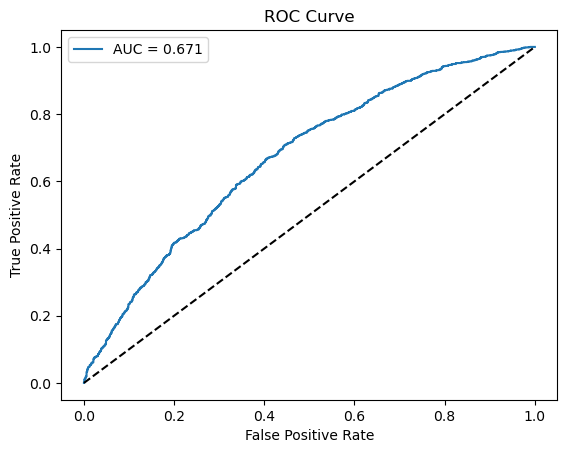

In [16]:
from sklearn.metrics import roc_auc_score
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for  x_val, team_a_val, team_b_val, batch_labels in val_dataloader:
        logits = model(x_val, team_a_val, team_b_val)
        probs = torch.sigmoid(logits)        
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(batch_labels.cpu().numpy().flatten())
auc = roc_auc_score(all_labels, all_probs)
print(f"Validation AUROC: {auc:.4f}")
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

TPR: 0.6223
FPR: 0.363
TNR: 0.637
FNR: 0.378


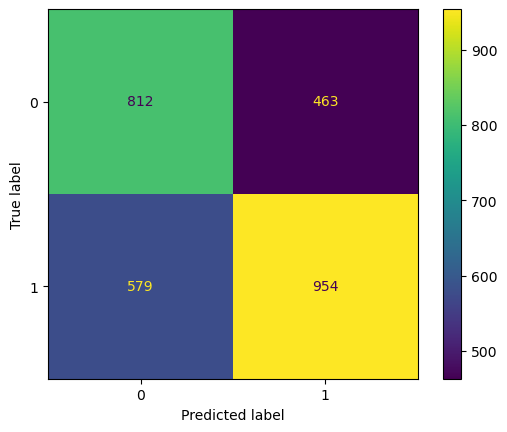

In [17]:
val_preds = np.array(val_preds_list, dtype=int) 
val_labels = np.array(val_labels_list, dtype=int)
conf_matrix = confusion_matrix(val_preds, val_labels)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  
fpr = fp / (fp + tn)  
tnr = tn / (tn + fp)  
fnr = fn / (fn + tp)  
print(f"TPR: {tpr:.4f}")
print(f"FPR: {fpr:.3f}")
print(f"TNR: {tnr:.3f}")
print(f"FNR: {fnr:.3f}")


In [18]:
class MLP_parallel(nn.Module): ##removes 1 dimensional ouput layer for parallel DCN archtitecture 
    def __init__(self, input_dim: int, hidden_dims:list): 
        super(MLP_parallel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0]) 
        self.ln1 = nn.LayerNorm(hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1]) 
        self.ln2 = nn.LayerNorm(hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], hidden_dims[2]) 
        self.ln3 = nn.LayerNorm(hidden_dims[2])
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x: torch.Tensor): 
        x = self.fc1(x) 
        x = self.ln1(x)
        x = self.relu(x) 
        x = self.dropout(x)

        x = self.fc2(x) 
        x = self.ln2(x)
        x = self.relu(x) 
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.ln3(x)
        x = self.relu(x)
        x = self.dropout(x)

        return x

In [19]:
class DCNV2_parallel(nn.Module): 
    def __init__(self, num_features: int, num_teams:int, embedding_dim: int, num_cross_layers: int, hidden_dims: list): 
        super(DCNV2_parallel, self).__init__()
        self.emb = nn.Embedding(num_embeddings=num_teams, embedding_dim=embedding_dim) #embedding layer for teams 
        total_features = num_features + (2*embedding_dim) 
        self.cross_net = CrossNetwork(input_dim=total_features, num_layers=num_cross_layers)
        self.mlp = MLP_parallel(input_dim=total_features, hidden_dims=hidden_dims)
        
        total_features = total_features + hidden_dims[2] # total num features after concatenating output from cross network and neural network 
        self.output = nn.Sequential(
            nn.Linear(total_features, 128), 
            nn.LayerNorm(128), 
            nn.ReLU(), 
            nn.Dropout(0.3), 
            nn.Linear(128,1))
        
    def forward(self, dense_features: torch.Tensor, team_a: torch.Tensor, team_b: torch.Tensor): 
        team_a_embedding = self.emb(team_a) 
        team_b_embedding = self.emb(team_b) 
        x0 = torch.cat([dense_features, team_a_embedding, team_b_embedding], dim=1) 
        cross_net_output = self.cross_net(x0)
        mlp_output = self.mlp(x0)
        x = torch.cat([cross_net_output, mlp_output], dim=1) # concatenate outputs of cross and neural network to feed into final layer 
        logits = self.output(x)
        return logits  

In [20]:
model = DCNV2_parallel(num_features=num_features, num_teams=num_teams, embedding_dim=embedding_dim, num_cross_layers=num_cross_layers, hidden_dims=hidden_dims) 
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.0001) 
criterion = nn.BCEWithLogitsLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, verbose=True)
best_val_loss = float('inf') 
patience = 5
patience_cntr = 0 
best_model_State = None 

/Users/sarmadahmed/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
epochs = 40

# training 
for epoch in range(epochs):
    model.train()
    running_train_loss = 0.0
    for x_train, team_a_train, team_b_train, batch_labels in train_dataloader: # Forward pass 
        logits = model(x_train, team_a_train, team_b_train)                               
        loss = criterion(logits, batch_labels)  # per batch loss 
        optimizer.zero_grad() # Backward pass 
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * x_train.size(0) 
        #total batch loss = loss per batch * num samples in batch
        # summing total loss for all batches in 1 epoch 
    train_loss = running_train_loss / len(train_dataset) # avg loss per sample

#validation 
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # Turn off gradient calculation for evaluation 
        for x_val, team_a_val, team_b_val, batch_labels in val_dataloader:
            logits = model(x_val, team_a_val, team_b_val)
            loss = criterion(logits, batch_labels)
            running_val_loss += loss.item() * x_val.size(0)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.50).float()
           
            correct += (preds == batch_labels).sum().item()
            total += batch_labels.numel()

    val_loss = running_val_loss / len(val_dataset)
    val_acc = 100.0 * correct / total
    
    print(f"Epoch [{epoch+1}/{epochs}]  " f"Train Loss: {train_loss:.4f}  " f"Val Loss: {val_loss:.4f}  "
          f"Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss: 
        best_val_loss = val_loss 
        patience_cntr = 0           
        best_model_state = model.state_dict() 
    else: 
        patience_cntr += 1 
        if patience_cntr == patience: 
            print(f'Early stopping at epoch {epoch+1} . Validation loss did not improve for {patience} epochs.') 
            break 

Epoch [1/40]  Train Loss: 0.6583  Val Loss: 0.6561  Val Acc: 61.82%
Epoch [2/40]  Train Loss: 0.6362  Val Loss: 0.6520  Val Acc: 61.65%
Epoch [3/40]  Train Loss: 0.6245  Val Loss: 0.6495  Val Acc: 62.00%
Epoch [4/40]  Train Loss: 0.6165  Val Loss: 0.6491  Val Acc: 62.18%
Epoch [5/40]  Train Loss: 0.6077  Val Loss: 0.6486  Val Acc: 62.78%
Epoch [6/40]  Train Loss: 0.6020  Val Loss: 0.6482  Val Acc: 62.75%
Epoch [7/40]  Train Loss: 0.5961  Val Loss: 0.6489  Val Acc: 62.78%
Epoch [8/40]  Train Loss: 0.5866  Val Loss: 0.6503  Val Acc: 63.28%
Epoch [9/40]  Train Loss: 0.5818  Val Loss: 0.6503  Val Acc: 62.78%
Epoch [10/40]  Train Loss: 0.5767  Val Loss: 0.6518  Val Acc: 63.07%
Epoch [11/40]  Train Loss: 0.5705  Val Loss: 0.6539  Val Acc: 62.78%
Early stopping at epoch 11 . Validation loss did not improve for 5 epochs.


In [22]:
## final evaluation using model weights from best epoch 

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print('Loaded best model state from early stopping for final evaluation')
else:
    print('Early stopping did not trigger. Using model from the last epoch.')

val_preds_list = []
val_labels_list = []
model.eval() 
final_val_loss = 0.0
final_correct = 0
final_total = 0
with torch.no_grad():
    for x_val, team_a_val, team_b_val, batch_labels in val_dataloader:
        logits = model(x_val, team_a_val, team_b_val)
        loss = criterion(logits, batch_labels)
        final_val_loss += loss.item() * x_val.size(0)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.50).float()
        
        val_preds_list.extend(preds.cpu().numpy().astype(int).tolist())
        val_labels_list.extend(batch_labels.cpu().numpy().astype(int).tolist())
        final_correct += (preds == batch_labels).sum().item()
        final_total += batch_labels.numel()

final_val_loss /= len(val_dataset)
final_val_acc = 100.0 * final_correct / final_total

print("\nBest Model Performance on Validation Set")
print(f"Final Val Loss: {final_val_loss:.4f}")
print(f"Final Val Acc: {final_val_acc:.2f}%")

Loaded best model state from early stopping for final evaluation

Best Model Performance on Validation Set
Final Val Loss: 0.6539
Final Val Acc: 62.78%


Validation AUROC: 0.6718


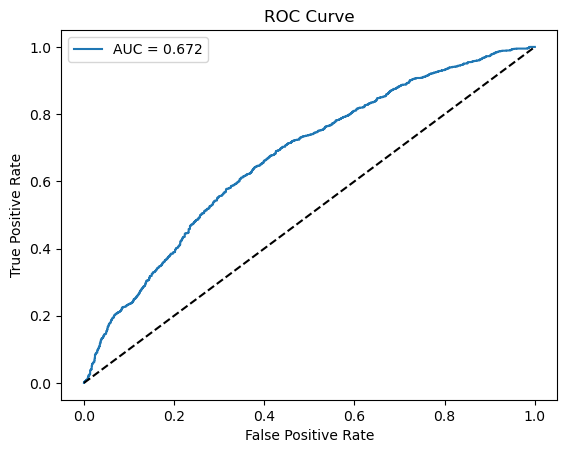

In [23]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for  x_val, team_a_val, team_b_val, batch_labels in val_dataloader:
        logits = model(x_val, team_a_val, team_b_val)
        probs = torch.sigmoid(logits)        
        all_probs.extend(probs.cpu().numpy().flatten())
        all_labels.extend(batch_labels.cpu().numpy().flatten())
auc = roc_auc_score(all_labels, all_probs)
print(f"Validation AUROC: {auc:.4f}")
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], 'k--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

TPR: 0.6398
FPR: 0.383
TNR: 0.617
FNR: 0.360


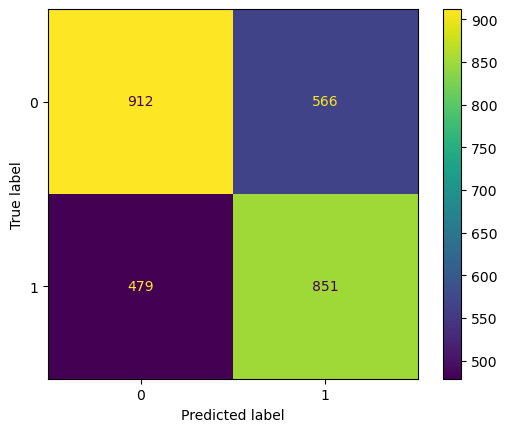

In [24]:
val_preds = np.array(val_preds_list, dtype=int) 
val_labels = np.array(val_labels_list, dtype=int)
conf_matrix = confusion_matrix(val_preds, val_labels)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  
fpr = fp / (fp + tn)  
tnr = tn / (tn + fp)  
fnr = fn / (fn + tp)  
print(f"TPR: {tpr:.4f}")
print(f"FPR: {fpr:.3f}")
print(f"TNR: {tnr:.3f}")
print(f"FNR: {fnr:.3f}")
